In [ ]:
import numpy as np

def Get_Feats_and_Targets(filename):
    import numpy as np

    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)

    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

    

[TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
# [ValInputs_Easy,ValTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

[TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
[ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')

TrainInputs = np.append(TrainInputs,TrainInputs_Easy,axis=0)
TrainTargets = np.append(TrainTargets,TrainTargets_Easy,axis=0)

[TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.test.amat')

In [ ]:
# %matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz
import seaborn as sns

from keras.layers.core import Lambda
from keras import backend as K    

data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    return model

D2THard_model = Gen_Model(reg_coeff)
D2TEasy_model = Gen_Model(reg_coeff)
BALDHard_model = Gen_Model(reg_coeff)
BALDEasy_model = Gen_Model(reg_coeff)

Uni_model = Gen_Model(reg_coeff)

D2THard_model.set_weights(Uni_model.get_weights())
D2TEasy_model.set_weights(Uni_model.get_weights())
BALDHard_model.set_weights(Uni_model.get_weights())
BALDEasy_model.set_weights(Uni_model.get_weights())

def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 30
    MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])

    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy

    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob


def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def acquisition_function_entropy(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Entropy = -np.sum(Output * np.log(Output),1)
    Exp_Entropy = np.exp(Entropy/temperature)
    Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Entropy = np.exp(Entropy/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Entropy = np.exp(Entropy/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

count = 0 
Num_Epochs = 350
Num_BurnIn = 1
Batch_Size = 32

Val_Error = np.zeros([Num_Epochs,4])
Val_Acc = np.zeros([Num_Epochs,4])

Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=Num_Epochs,verbose=1)

Dist_to_Threshold = acquisition_function_dist_to_threshold(Uni_model,TrainInputs,Num_Targets,1,10)
BALD = acquisition_function_BALD(Uni_model,TrainInputs,Num_Targets,1,10)

#'Easiest' First
Easy_Dist_to_Threshold_ArgSort = np.flipud(Dist_to_Threshold.argsort())

Using TensorFlow backend.


Epoch 1/350
20000/20000 [==============================] - 5s 257us/step - loss: 1.1738 - categorical_accuracy: 0.3348
Epoch 2/350
20000/20000 [==============================] - 5s 243us/step - loss: 1.1373 - categorical_accuracy: 0.3535
Epoch 3/350
20000/20000 [==============================] - 5s 243us/step - loss: 1.1286 - categorical_accuracy: 0.3578
Epoch 4/350
20000/20000 [==============================] - 5s 243us/step - loss: 1.1210 - categorical_accuracy: 0.3663
Epoch 5/350
20000/20000 [==============================] - 5s 244us/step - loss: 1.1105 - categorical_accuracy: 0.3735
Epoch 6/350
20000/20000 [==============================] - 5s 244us/step - loss: 1.1047 - categorical_accuracy: 0.3866
Epoch 7/350
20000/20000 [==============================] - 5s 240us/step - loss: 1.0960 - categorical_accuracy: 0.3951
Epoch 8/350
20000/20000 [==============================] - 5s 240us/step - loss: 1.0907 - categorical_accuracy: 0.3998
Epoch 9/350
20000/20000 [=======================

20000/20000 [==============================] - 5s 240us/step - loss: 0.6641 - categorical_accuracy: 0.7087
Epoch 70/350
20000/20000 [==============================] - 5s 240us/step - loss: 0.6675 - categorical_accuracy: 0.7093
Epoch 71/350
20000/20000 [==============================] - 5s 240us/step - loss: 0.6669 - categorical_accuracy: 0.7101
Epoch 72/350
20000/20000 [==============================] - 5s 240us/step - loss: 0.6543 - categorical_accuracy: 0.7142
Epoch 73/350
20000/20000 [==============================] - 5s 241us/step - loss: 0.6510 - categorical_accuracy: 0.7137
Epoch 74/350
20000/20000 [==============================] - 5s 241us/step - loss: 0.6504 - categorical_accuracy: 0.7166
Epoch 75/350
20000/20000 [==============================] - 5s 233us/step - loss: 0.6466 - categorical_accuracy: 0.7213
Epoch 76/350
20000/20000 [==============================] - 5s 241us/step - loss: 0.6443 - categorical_accuracy: 0.7203
Epoch 77/350
20000/20000 [===========================

In [126]:
Task1 = Easy_Dist_to_Threshold_ArgSort[0:10000]
Task2 = Easy_Dist_to_Threshold_ArgSort[10000:]

Task1_Easy_Prop = Task1[Task1 > 10000]
Task1_Easy_Prop =  Task1_Easy_Prop.shape[0]/Task1.shape[0]

# Class Balance
# Proportion from 'easy' training set
# Distribution of Dist_to_Threshold

<IPython.core.display.Javascript object>


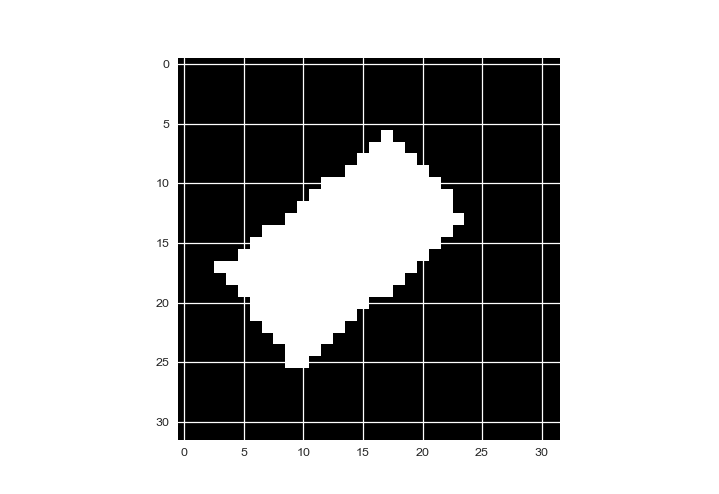

In [141]:
plt.imshow(np.reshape(TrainInputs[0,:],[32,32]))
plt.show()

In [127]:
Task1_TrainInputs= TrainInputs[Task1,:]
Task2_TrainInputs = TrainInputs[Task2,:]
Task1_TrainTargets = TrainTargets[Task1,:]
Task2_TrainTargets = TrainTargets[Task2,:]

In [136]:
Task1_TrainInputs.dtype

dtype('float64')

In [75]:
Task1_TrainTargets.mean(axis=0)

array([0.2623, 0.3053, 0.4324])

In [133]:
del fig
del axes
import matplotlib.pyplot as plt
plt.imshow()

In [140]:
# import numpy as np
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# randind = np.random.randint(0,Task1_TrainInputs.shape[0],size = 4)
# axes[0,0].imshow(np.reshape(Task1_TrainInputs[randind[0],:],[32,32]))
# axes[1,0].imshow(np.reshape(Task1_TrainInputs[randind[1],:],[32,32]))
# axes[0,1].imshow(np.reshape(Task1_TrainInputs[randind[2],:],[32,32]))
# axes[1,1].imshow(np.reshape(Task1_TrainInputs[randind[3],:],[32,32]))
# plt.show()

In [2]:
def GeoShapes_Bootstrap_Exp(TrainInputs,TrainTargets,ValInputs,ValTargets,TestInputs,TestTargets,NumTasks,Num_Epochs = 256):
    %matplotlib notebook
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz
    import seaborn as sns

    from keras.layers.core import Lambda
    from keras import backend as K    

    data_dim = TrainInputs.shape[-1]
    NumSamples = TrainInputs.shape[0]
    Num_Targets = TrainTargets.shape[-1]

    index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

    reg_coeff = 0

    def Gen_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
        return model

    D2THard_model = Gen_Model(reg_coeff)
    D2TEasy_model = Gen_Model(reg_coeff)
    BALDHard_model = Gen_Model(reg_coeff)
    BALDEasy_model = Gen_Model(reg_coeff)

    Uni_model = Gen_Model(reg_coeff)

    D2THard_model.set_weights(Uni_model.get_weights())
    D2TEasy_model.set_weights(Uni_model.get_weights())
    BALDHard_model.set_weights(Uni_model.get_weights())
    BALDEasy_model.set_weights(Uni_model.get_weights())

    def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
        nb_MC_samples = 30
        MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
        MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
        learning_phase = True 
        for i in range(nb_MC_samples):
            MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])

        expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
        expected_p = np.mean(MC_samples, axis=0)
        entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
        BALD_acq = entropy_expected_p - expected_entropy

        Exp_BALD = np.exp(BALD_acq/temperature)
        Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob


    def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Exp_Dist_to_Threshold *= 1
    #     Exp_Dist_to_Threshold = Dist_to_Threshold
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob

    def acquisition_function_entropy(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Entropy = -np.sum(Output * np.log(Output),1)
        Exp_Entropy = np.exp(Entropy/temperature)
        Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Entropy = np.exp(Entropy/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Entropy = np.exp(Entropy/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob

    count = 0 
    Num_Epochs = Num_Epochs
    Num_BurnIn = 1
    Batch_Size = 32

    Val_Error = np.zeros([Num_Epochs,4])
    Val_Acc = np.zeros([Num_Epochs,4])

    Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=Num_Epochs,verbose=1)

    Dist_to_Threshold = acquisition_function_dist_to_threshold(Uni_model,TrainInputs,Num_Targets,1,10)
    BALD = acquisition_function_BALD(Uni_model,TrainInputs,Num_Targets,1,10)

    #'Easiest' First
    Easy_Dist_to_Threshold_ArgSort = np.flipud(Dist_to_Threshold.argsort())
    Hard_Dist_to_Threshold_ArgSort = Dist_to_Threshold.argsort()
    Low_BALD_ArgSort = BALD.argsort()
    High_BALD_ArgSort = np.flipud(BALD.argsort())

    NumTasks = NumTasks
    TaskSplitPoints = np.int(NumSamples/NumTasks)
    print(TaskSplitPoints)
    for i in range(NumTasks):
        Num_Epochs_Task = Num_Epochs*(1/(i+1))

        TaskInd = Hard_Dist_to_Threshold_ArgSort[0:(i+1)*TaskSplitPoints]
        D2THard_model.fit(TrainInputs[TaskInd,:],TrainTargets[TaskInd],batch_size=Batch_Size,epochs = np.int(Num_Epochs_Task))

        TaskInd = Easy_Dist_to_Threshold_ArgSort[0:(i+1)*TaskSplitPoints]
        D2TEasy_model.fit(TrainInputs[TaskInd,:],TrainTargets[TaskInd],batch_size=Batch_Size,epochs = np.int(Num_Epochs_Task))

#         TaskInd = Low_BALD_ArgSort[0:(i+1)*TaskSplitPoints]
#         BALDEasy_model.fit(TrainInputs[TaskInd,:],TrainTargets[TaskInd],batch_size=Batch_Size,epochs = np.int(Num_Epochs_Task))

#         TaskInd = High_BALD_ArgSort[0:(i+1)*TaskSplitPoints]
#         BALDHard_model.fit(TrainInputs[TaskInd,:],TrainTargets[TaskInd],batch_size=Batch_Size,epochs = np.int(Num_Epochs_Task))

    

    TestError = np.zeros([5,2])
    TestError[0,:] = D2THard_model.test_on_batch(TestInputs,TestTargets)
    TestError[1,:] = D2TEasy_model.test_on_batch(TestInputs,TestTargets)
    TestError[2,:] = BALDHard_model.test_on_batch(TestInputs,TestTargets)
    TestError[3,:] = BALDEasy_model.test_on_batch(TestInputs,TestTargets)
    TestError[4,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
    
    
    return TestError

In [3]:
NumTests = 100

NumTasks = np.array([2])

TestError_Record = np.zeros([5,2,NumTests,NumTasks.shape[0]])



In [4]:
from IPython.display import clear_output

for i in range(NumTests):
    for j in range(NumTasks.shape[0]):
        clear_output()
        print('Run:')
        print(i)
        print('NumTasks:')
        print(NumTasks[j])
        TestError_Record[:,:,i,j] = GeoShapes_Bootstrap_Exp(TrainInputs,TrainTargets,
                                                            ValInputs,ValTargets,TestInputs,
                                                            TestTargets,NumTasks[j],350)
        np.save('',TestError_Record)

Run:
24
NumTasks:
2
Epoch 1/350
20000/20000 [==============================] - 10s 519us/step - loss: 1.1730 - categorical_accuracy: 0.3399
Epoch 2/350
20000/20000 [==============================] - 6s 288us/step - loss: 1.1499 - categorical_accuracy: 0.3454
Epoch 3/350
20000/20000 [==============================] - 6s 288us/step - loss: 1.1331 - categorical_accuracy: 0.3538
Epoch 4/350
20000/20000 [==============================] - 6s 287us/step - loss: 1.1277 - categorical_accuracy: 0.3622
Epoch 5/350
20000/20000 [==============================] - 6s 286us/step - loss: 1.1188 - categorical_accuracy: 0.3725
Epoch 6/350
20000/20000 [==============================] - 6s 288us/step - loss: 1.1134 - categorical_accuracy: 0.3837
Epoch 7/350
20000/20000 [==============================] - 6s 287us/step - loss: 1.1045 - categorical_accuracy: 0.3887
Epoch 8/350
20000/20000 [==============================] - 6s 288us/step - loss: 1.0939 - categorical_accuracy: 0.4013
Epoch 9/350
20000/20000 [==

20000/20000 [==============================] - 6s 286us/step - loss: 0.4714 - categorical_accuracy: 0.8030
Epoch 138/350
20000/20000 [==============================] - 6s 286us/step - loss: 0.4674 - categorical_accuracy: 0.8073
Epoch 139/350
20000/20000 [==============================] - 6s 286us/step - loss: 0.4597 - categorical_accuracy: 0.8082
Epoch 140/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.4632 - categorical_accuracy: 0.8048
Epoch 141/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.4643 - categorical_accuracy: 0.8030
Epoch 142/350
20000/20000 [==============================] - 6s 288us/step - loss: 0.4681 - categorical_accuracy: 0.8041
Epoch 143/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.4613 - categorical_accuracy: 0.8056
Epoch 144/350
20000/20000 [==============================] - 6s 288us/step - loss: 0.4499 - categorical_accuracy: 0.8135
Epoch 145/350
20000/20000 [===================

20000/20000 [==============================] - 6s 287us/step - loss: 0.3148 - categorical_accuracy: 0.8724
Epoch 272/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.3113 - categorical_accuracy: 0.8736
Epoch 273/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.3176 - categorical_accuracy: 0.8737
Epoch 274/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.3084 - categorical_accuracy: 0.8784
Epoch 275/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.3096 - categorical_accuracy: 0.8750
Epoch 276/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.3022 - categorical_accuracy: 0.8795
Epoch 277/350
20000/20000 [==============================] - 6s 287us/step - loss: 0.3084 - categorical_accuracy: 0.8762
Epoch 278/350
20000/20000 [==============================] - 6s 288us/step - loss: 0.3142 - categorical_accuracy: 0.8742
Epoch 279/350
20000/20000 [===================

10000/10000 [==============================] - 3s 284us/step - loss: 1.0594 - categorical_accuracy: 0.4169
Epoch 57/350
10000/10000 [==============================] - 3s 293us/step - loss: 1.0568 - categorical_accuracy: 0.4196
Epoch 58/350
10000/10000 [==============================] - 3s 285us/step - loss: 1.0548 - categorical_accuracy: 0.4207
Epoch 59/350
10000/10000 [==============================] - 3s 287us/step - loss: 1.0564 - categorical_accuracy: 0.4271
Epoch 60/350
10000/10000 [==============================] - 3s 286us/step - loss: 1.0561 - categorical_accuracy: 0.4223
Epoch 61/350
10000/10000 [==============================] - 3s 286us/step - loss: 1.0558 - categorical_accuracy: 0.4195
Epoch 62/350
10000/10000 [==============================] - 3s 286us/step - loss: 1.0551 - categorical_accuracy: 0.4221
Epoch 63/350
10000/10000 [==============================] - 3s 285us/step - loss: 1.0535 - categorical_accuracy: 0.4267
Epoch 64/350
10000/10000 [===========================

10000/10000 [==============================] - 3s 289us/step - loss: 0.8540 - categorical_accuracy: 0.5866
Epoch 192/350
10000/10000 [==============================] - 3s 288us/step - loss: 0.8666 - categorical_accuracy: 0.5760
Epoch 193/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.8564 - categorical_accuracy: 0.5785
Epoch 194/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.8592 - categorical_accuracy: 0.5783
Epoch 195/350
10000/10000 [==============================] - 3s 287us/step - loss: 0.8449 - categorical_accuracy: 0.5934
Epoch 196/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.8566 - categorical_accuracy: 0.5826
Epoch 197/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.8487 - categorical_accuracy: 0.5840
Epoch 198/350
10000/10000 [==============================] - 3s 287us/step - loss: 0.8554 - categorical_accuracy: 0.5787
Epoch 199/350
10000/10000 [===================

10000/10000 [==============================] - 3s 288us/step - loss: 0.6991 - categorical_accuracy: 0.6777
Epoch 326/350
10000/10000 [==============================] - 3s 288us/step - loss: 0.7052 - categorical_accuracy: 0.6753
Epoch 327/350
10000/10000 [==============================] - 3s 290us/step - loss: 0.6904 - categorical_accuracy: 0.6847
Epoch 328/350
10000/10000 [==============================] - 3s 288us/step - loss: 0.6978 - categorical_accuracy: 0.6777
Epoch 329/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.6943 - categorical_accuracy: 0.6820
Epoch 330/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.6963 - categorical_accuracy: 0.6840
Epoch 331/350
10000/10000 [==============================] - 3s 287us/step - loss: 0.6971 - categorical_accuracy: 0.6771
Epoch 332/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.6865 - categorical_accuracy: 0.6830
Epoch 333/350
10000/10000 [===================

10000/10000 [==============================] - 3s 288us/step - loss: 0.1251 - categorical_accuracy: 0.9539
Epoch 112/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.1296 - categorical_accuracy: 0.9515
Epoch 113/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.1238 - categorical_accuracy: 0.9559
Epoch 114/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.1180 - categorical_accuracy: 0.9584
Epoch 115/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.1206 - categorical_accuracy: 0.9561
Epoch 116/350
10000/10000 [==============================] - 3s 290us/step - loss: 0.1098 - categorical_accuracy: 0.9608
Epoch 117/350
10000/10000 [==============================] - 3s 290us/step - loss: 0.1204 - categorical_accuracy: 0.9580
Epoch 118/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.1026 - categorical_accuracy: 0.9633
Epoch 119/350
10000/10000 [===================

10000/10000 [==============================] - 3s 291us/step - loss: 0.0480 - categorical_accuracy: 0.9844
Epoch 246/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.0554 - categorical_accuracy: 0.9809
Epoch 247/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.0452 - categorical_accuracy: 0.9839
Epoch 248/350
10000/10000 [==============================] - 3s 290us/step - loss: 0.0360 - categorical_accuracy: 0.9888
Epoch 249/350
10000/10000 [==============================] - 3s 290us/step - loss: 0.0476 - categorical_accuracy: 0.9841
Epoch 250/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.0491 - categorical_accuracy: 0.9837
Epoch 251/350
10000/10000 [==============================] - 3s 289us/step - loss: 0.0560 - categorical_accuracy: 0.9809
Epoch 252/350
10000/10000 [==============================] - 3s 290us/step - loss: 0.0318 - categorical_accuracy: 0.9889
Epoch 253/350
10000/10000 [===================

20000/20000 [==============================] - 6s 286us/step - loss: 0.5643 - categorical_accuracy: 0.7589
Epoch 31/175
20000/20000 [==============================] - 6s 286us/step - loss: 0.5507 - categorical_accuracy: 0.7675
Epoch 32/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.5499 - categorical_accuracy: 0.7681
Epoch 33/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.5394 - categorical_accuracy: 0.7722
Epoch 34/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.5420 - categorical_accuracy: 0.7718
Epoch 35/175
20000/20000 [==============================] - 6s 286us/step - loss: 0.5426 - categorical_accuracy: 0.7744
Epoch 36/175
20000/20000 [==============================] - 6s 286us/step - loss: 0.5330 - categorical_accuracy: 0.7768
Epoch 37/175
20000/20000 [==============================] - 6s 289us/step - loss: 0.5301 - categorical_accuracy: 0.7773
Epoch 38/175
20000/20000 [===========================

20000/20000 [==============================] - 6s 286us/step - loss: 0.3083 - categorical_accuracy: 0.8756
Epoch 166/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3177 - categorical_accuracy: 0.8743
Epoch 167/175
20000/20000 [==============================] - 6s 286us/step - loss: 0.3134 - categorical_accuracy: 0.8754
Epoch 168/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3141 - categorical_accuracy: 0.8735
Epoch 169/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3159 - categorical_accuracy: 0.8732
Epoch 170/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3171 - categorical_accuracy: 0.8752
Epoch 171/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3098 - categorical_accuracy: 0.8740
Epoch 172/175
20000/20000 [==============================] - 6s 286us/step - loss: 0.3125 - categorical_accuracy: 0.8776
Epoch 173/175
20000/20000 [===================

20000/20000 [==============================] - 6s 286us/step - loss: 0.3401 - categorical_accuracy: 0.8628
Epoch 127/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3226 - categorical_accuracy: 0.8712
Epoch 128/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3272 - categorical_accuracy: 0.8690
Epoch 129/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3329 - categorical_accuracy: 0.8650
Epoch 130/175
20000/20000 [==============================] - 6s 291us/step - loss: 0.3147 - categorical_accuracy: 0.8728
Epoch 131/175
20000/20000 [==============================] - 6s 288us/step - loss: 0.3260 - categorical_accuracy: 0.8683
Epoch 132/175
20000/20000 [==============================] - 6s 289us/step - loss: 0.3116 - categorical_accuracy: 0.8726
Epoch 133/175
20000/20000 [==============================] - 6s 287us/step - loss: 0.3248 - categorical_accuracy: 0.8706
Epoch 134/175
20000/20000 [===================

KeyboardInterrupt: 

In [2]:
def GeoShapes_Manual_Curric(TrainInputs,TrainTargets,ValInputs,ValTargets,TestInputs,TestTargets,Num_Epochs = 256):
    %matplotlib notebook
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz
    import seaborn as sns

    from keras.layers.core import Lambda
    from keras import backend as K    

    data_dim = TrainInputs.shape[-1]
    NumSamples = TrainInputs.shape[0]
    Num_Targets = TrainTargets.shape[-1]

    reg_coeff = 0

    def Gen_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
        return model

    Curric_model = Gen_Model(reg_coeff)

    count = 0 
    Num_Epochs = Num_Epochs
    Num_BurnIn = 1
    Batch_Size = 32

#     Easy Samples
    Curric_model.fit(TrainInputs[10000:,:],TrainTargets[10000:,:],batch_size = Batch_Size,epochs=np.int(Num_Epochs),verbose=1)
#     Hard Samples
    Curric_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=np.int(Num_Epochs/2),verbose=1)
    

    TestError = Curric_model.test_on_batch(TestInputs,TestTargets)    
    
    return TestError

In [3]:
NumTests = 25

NumTasks = np.array([2])

Curric_TestError_Record = np.zeros([NumTests,2])

from IPython.display import clear_output

for i in range(NumTests):
    clear_output()
    print('Run:')
    print(i)
    Curric_TestError_Record[i,:] = GeoShapes_Manual_Curric(TrainInputs,TrainTargets,
                                                        ValInputs,ValTargets,TestInputs,
                                                        TestTargets,350)
    np.save('GeoShapes_Curric_Baseline_350_UnAdj',Curric_TestError_Record)

Run:
24
Epoch 1/175
10000/10000 [==============================] - 4s 361us/step - loss: 1.1915 - categorical_accuracy: 0.3427
Epoch 2/175
10000/10000 [==============================] - 2s 236us/step - loss: 1.1636 - categorical_accuracy: 0.3424
Epoch 3/175
10000/10000 [==============================] - 2s 234us/step - loss: 1.1450 - categorical_accuracy: 0.3516
Epoch 4/175
10000/10000 [==============================] - 2s 235us/step - loss: 1.1316 - categorical_accuracy: 0.3629
Epoch 5/175
10000/10000 [==============================] - 2s 235us/step - loss: 1.1238 - categorical_accuracy: 0.3662
Epoch 6/175
10000/10000 [==============================] - 2s 240us/step - loss: 1.1243 - categorical_accuracy: 0.3720
Epoch 7/175
10000/10000 [==============================] - 2s 236us/step - loss: 1.1167 - categorical_accuracy: 0.3798
Epoch 8/175
10000/10000 [==============================] - 2s 233us/step - loss: 1.0995 - categorical_accuracy: 0.3940
Epoch 9/175
10000/10000 [===============

10000/10000 [==============================] - 2s 234us/step - loss: 0.5615 - categorical_accuracy: 0.7579
Epoch 70/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.5554 - categorical_accuracy: 0.7617
Epoch 71/175
10000/10000 [==============================] - 2s 237us/step - loss: 0.5561 - categorical_accuracy: 0.7618
Epoch 72/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.5598 - categorical_accuracy: 0.7599
Epoch 73/175
10000/10000 [==============================] - 2s 232us/step - loss: 0.5479 - categorical_accuracy: 0.7643
Epoch 74/175
10000/10000 [==============================] - 2s 230us/step - loss: 0.5377 - categorical_accuracy: 0.7654
Epoch 75/175
10000/10000 [==============================] - 2s 234us/step - loss: 0.5401 - categorical_accuracy: 0.7711
Epoch 76/175
10000/10000 [==============================] - 2s 234us/step - loss: 0.5347 - categorical_accuracy: 0.7675
Epoch 77/175
10000/10000 [===========================

10000/10000 [==============================] - 2s 235us/step - loss: 0.3633 - categorical_accuracy: 0.8512
Epoch 138/175
10000/10000 [==============================] - 2s 230us/step - loss: 0.3582 - categorical_accuracy: 0.8535
Epoch 139/175
10000/10000 [==============================] - 2s 233us/step - loss: 0.3991 - categorical_accuracy: 0.8368
Epoch 140/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.3557 - categorical_accuracy: 0.8588
Epoch 141/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.3555 - categorical_accuracy: 0.8553
Epoch 142/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.3599 - categorical_accuracy: 0.8515
Epoch 143/175
10000/10000 [==============================] - 2s 237us/step - loss: 0.3605 - categorical_accuracy: 0.8489
Epoch 144/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.3533 - categorical_accuracy: 0.8572
Epoch 145/175
10000/10000 [===================

10000/10000 [==============================] - 2s 235us/step - loss: 0.7937 - categorical_accuracy: 0.6417
Epoch 31/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.7846 - categorical_accuracy: 0.6481
Epoch 32/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.7784 - categorical_accuracy: 0.6559
Epoch 33/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.7771 - categorical_accuracy: 0.6512
Epoch 34/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.7725 - categorical_accuracy: 0.6559
Epoch 35/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.7646 - categorical_accuracy: 0.6591
Epoch 36/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.7725 - categorical_accuracy: 0.6511
Epoch 37/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.7637 - categorical_accuracy: 0.6602
Epoch 38/175
10000/10000 [===========================

10000/10000 [==============================] - 2s 235us/step - loss: 0.6128 - categorical_accuracy: 0.7398
Epoch 99/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.6171 - categorical_accuracy: 0.7409
Epoch 100/175
10000/10000 [==============================] - 2s 234us/step - loss: 0.6114 - categorical_accuracy: 0.7428
Epoch 101/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.6091 - categorical_accuracy: 0.7369
Epoch 102/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.5981 - categorical_accuracy: 0.7454
Epoch 103/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.6127 - categorical_accuracy: 0.7416
Epoch 104/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.6074 - categorical_accuracy: 0.7454
Epoch 105/175
10000/10000 [==============================] - 2s 234us/step - loss: 0.5955 - categorical_accuracy: 0.7508
Epoch 106/175
10000/10000 [====================

10000/10000 [==============================] - 2s 233us/step - loss: 0.5037 - categorical_accuracy: 0.7924
Epoch 166/175
10000/10000 [==============================] - 2s 232us/step - loss: 0.5059 - categorical_accuracy: 0.7967
Epoch 167/175
10000/10000 [==============================] - 2s 233us/step - loss: 0.5087 - categorical_accuracy: 0.7897
Epoch 168/175
10000/10000 [==============================] - 2s 235us/step - loss: 0.5102 - categorical_accuracy: 0.7904
Epoch 169/175
10000/10000 [==============================] - 2s 236us/step - loss: 0.5020 - categorical_accuracy: 0.7959
Epoch 170/175
10000/10000 [==============================] - 2s 233us/step - loss: 0.4987 - categorical_accuracy: 0.7969
Epoch 171/175
10000/10000 [==============================] - 2s 230us/step - loss: 0.5009 - categorical_accuracy: 0.7919
Epoch 172/175
10000/10000 [==============================] - 2s 237us/step - loss: 0.4821 - categorical_accuracy: 0.8073
Epoch 173/175
10000/10000 [===================